# Self-Organizing Maps (SOMs)

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [8]:
# We need to define a custom Model

class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """

    def __init__(self, m, n, dim, niter, alpha=None, sigma=None):
        super(SOM, self).__init__()

        self.m = m
        self.n = n
        self.dim = dim
        self.niter = niter

        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)

        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)

        self.weights = torch.randn(m * n, dim)
        self.locations = torch.LongTensor(np.array(list(self.neuron_locations())))
        self.pdist = nn.PairwiseDistance(p=2)

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def neuron_locations(self):
        for i in range(self.m):
            for j in range(self.n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self.weights))],
                            key=lambda x: np.linalg.norm(vect - self.weights[x]))
            to_return.append(self.locations[min_index])

        return to_return

    def forward(self, x, it):
        dists = self.pdist(torch.stack([x for i in range(self.m * self.n)]), self.weights)
        _, bmu_index = torch.min(dists, 0)  # The "Winner Neuron"
        bmu_loc = self.locations[bmu_index, :]
        bmu_loc = bmu_loc.squeeze()

        learning_rate_op = 1.0 - it / self.niter
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        bmu_distance_squares = torch.sum(
            torch.pow(self.locations.float() - torch.stack([bmu_loc for i in range(self.m * self.n)]).float(), 2), 1)

        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op ** 2)))

        learning_rate_op = alpha_op * neighbourhood_func

        learning_rate_multiplier = torch.stack(
            [learning_rate_op[i:i + 1].repeat(self.dim) for i in range(self.m * self.n)])
        delta = torch.mul(learning_rate_multiplier, (torch.stack([x for i in range(self.m * self.n)]) - self.weights))
        new_weights = torch.add(self.weights, delta)
        self.weights = new_weights

In [13]:
m = 20
n = 30

#Training inputs for RGBcolors
colors = np.array([
    [0., 0., 0.],
    [0., 0., 1.],
    [0., 0., 0.5],
    [0.125, 0.529, 1.0],
    [0.33, 0.4, 0.67],
    [0.6, 0.5, 1.0],
    [0., 1., 0.],
    [1., 0., 0.],
    [0., 1., 1.],
    [1., 0., 1.],
    [1., 1., 0.],
    [1., 1., 1.],
    [.33, .33, .33],
    [.5, .5, .5],
    [.66, .66, .66]
])

color_names = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

In [14]:
# We want to map the points in a 2D representation so that similar colors are close

data = list()
for i in range(colors.shape[0]):
    data.append(torch.FloatTensor(colors[i,:]))

#Train a 20x30 SOM with 200 iterations
n_iter = 200
som = SOM(m, n, 3, n_iter)
for iter_no in range(n_iter):
    #Train with each vector one by one
    for i in range(len(data)):
        som(data[i], iter_no)

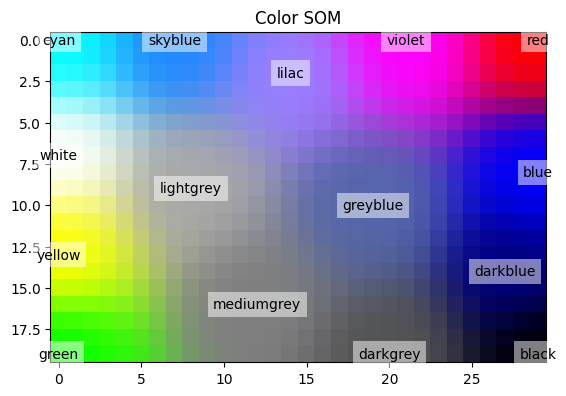

In [15]:
#Store a centroid grid for easy retrieval later on
centroid_grid = [[] for i in range(m)]
weights = som.get_weights()
locations = som.get_locations()
for i, loc in enumerate(locations):
    centroid_grid[loc[0]].append(weights[i].numpy())

#Get output grid
image_grid = centroid_grid

#Map colours to their closest neurons
mapped = som.map_vects(torch.Tensor(colors))

#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

# Notice that the labels are the original 15 points of the dataset